# Cleaning and pre-processing of Airbnb data 

### Importing the libraries and data

In [1]:
from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
!pip install geopandas
!pip install xgboost
!pip install pydot

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 994 kB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 6.5 MB 21.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 71.5 MB/s eta 0:00:01
     |████████████████████████████████| 15.4 MB 73.6 MB/s eta 0:00:01
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils imp

In [3]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [4]:
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 100)

In [5]:
airbnb_df = pd.read_csv('s3://divyam-personal/divyam/listings_berlin.csv.gz')

In [6]:
airbnb_df.shape

(24462, 106)

In [7]:
airbnb_df.describe(include="all")

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,2.446200e+04,24462,2.446200e+04,24462,24411,23261,15928,24054,24462,13626,7898,15007,11337,12209,12415,0.0,0.0,24462,0.0,2.446200e+04,24462,24422,24422,24334,12086,13852,13852,0.0,24422,24422,24422,19197,24422.000000,24422.000000,24462,24422,24422,24462,24462,24462,24462,24453,24327,23915,24402,24462,24462,24462,24462.000000,24462.000000,24462,24462,24462,24462.000000,24438.000000,24438.000000,24435.000000,24462,24462,432.000000,24462,3196,2303,14964,17295,24462.000000,24462,24462.000000,24462.000000,24462.000000,24462.000000,24462.000000,24462.000000,24462.000000,24462.000000,24462,24462,24462.000000,24462.000000,24462.000000,24462.000000,24462,24462.000000,24462.000000,20420,20420,19952.000000,19927.000000,19930.000000,19909.000000,19926.000000,19910.000000,19907.000000,24462,2550,0.0,24462,24462,24462,24462,24462,24462.000000,24462.000000,24462.000000,24462.000000,20420.000000
unique,NaN,24462,NaN,2,23757,22494,15260,23568,1,12526,7150,13998,10230,11048,11002,NaN,NaN,24209,NaN,NaN,20427,6406,3243,1077,9378,4,70,NaN,2,20324,20324,189,NaN,NaN,330,2,2,97,93,138,12,64,30,212,6,67,3,3,NaN,NaN,2,33,4,NaN,NaN,NaN,NaN,5,21776,NaN,335,371,395,162,124,NaN,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85,1,NaN,NaN,NaN,NaN,2,NaN,NaN,2519,1598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2145,NaN,2,1,6,2,2,NaN,NaN,NaN,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/5448528,NaN,2019-10-17,Cozy room in Berlin,"with en-suite bathroom, TV, WIFI, bed linen, a...",The Singer 109 Hostel is located in the heart ...,"with en-suite bathroom, TV, WIFI, bed linen, a...",none,Welcome Traveler. The Singer Hostel and Apart...,Since 01.01.2014 the city of Berlin had to ado...,U-Bahn / Underground /Subway / Metro: U5 (Stra...,Die Rezeption ist von 9Uhr bis 21Uhr besetzt. ...,Since I’ll be traveling myself during your sta...,"- Most importantly, please have a respectful a...",NaN,NaN,https://a0.muscache.com/im/pictures/f5c74865-b...,NaN,NaN,https://www.airbnb.com/users/show/1625771,Anna,2017-02-20,"Berlin, Berlin, Germany",.,within an hour,100%,NaN,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,Neukölln,NaN,NaN,"['email', 'phone', 'reviews']",t,f,"Berlin, Berlin, Germany",Neukölln,Frankfurter Allee Süd FK,Friedrichshain

### Columns to be dropped which are not to be used in current research problem

In [8]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped','calendar_updated']
airbnb_df.drop(cols_to_drop, axis=1, inplace=True)

# Checking null values

In [9]:
airbnb_df.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                         40
host_response_time                              10610
host_response_rate                              10610
host_acceptance_rate                            24462
host_is_superhost                                  40
host_listings_count                                40
host_total_listings_count                          40
host_has_profile_pic                               40
host_identity_verified                             40
street                                              0
neighbourhood                                       0
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
city                                                9
state                                             135
zipcode                                           547
market                      

In [10]:
#dropping columns with null values
airbnb_df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

handling f and t in boolean columns

In [11]:
# Replacing columns with f/t with boolean values
airbnb_df.replace({'f': 0, 't': 1}, inplace=True)

In [12]:
airbnb_df.loc[(airbnb_df.host_listings_count == airbnb_df.host_total_listings_count)].shape

(24422, 71)

In [13]:
airbnb_df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

minimum nights and minimum_minimum_nights are the same in most of the cases , hence one of the column to be dropped

In [14]:
airbnb_df.loc[(airbnb_df.minimum_nights == airbnb_df.minimum_minimum_nights)].shape

(23614, 66)

In [15]:
airbnb_df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

apart from city and country columns rest columns for location are dropped as they will not be used in research

In [16]:
lat_long = airbnb_df[['latitude', 'longitude']]

In [17]:
airbnb_df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'state', 'market', 'smart_location', 'country_code','is_location_exact'], axis=1, inplace=True)

# Understanding distribution of all columns 

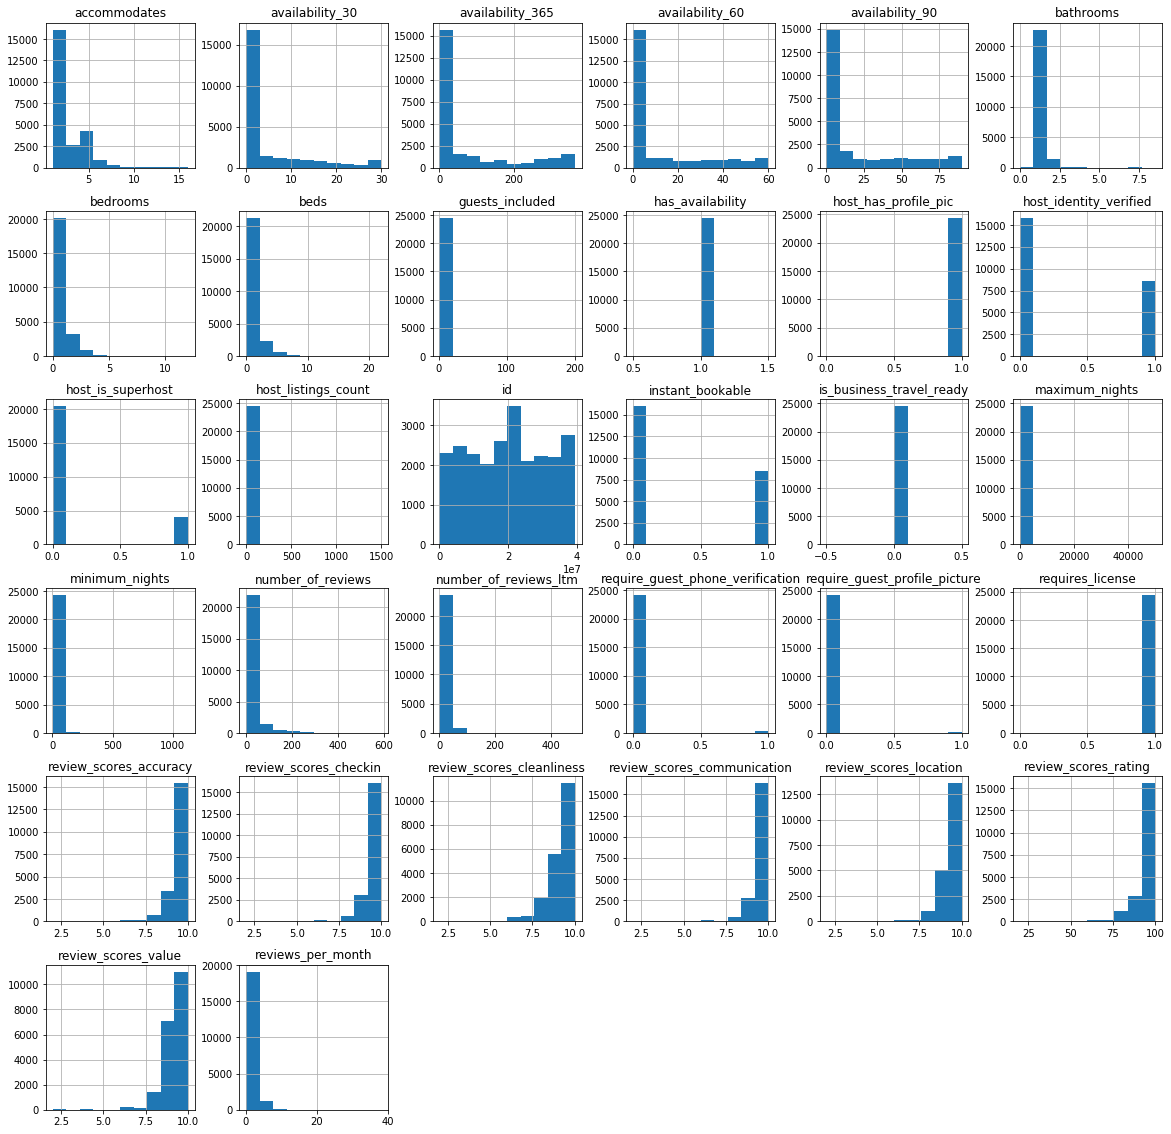

In [18]:
airbnb_df.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [19]:
airbnb_df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

host since is used to understand how many days host has been there on platform

In [20]:
# Converting to datetime
airbnb_df.host_since = pd.to_datetime(airbnb_df.host_since) 

# Calculating the number of days
airbnb_df['host_days_active'] = (datetime(2019, 9, 15) - airbnb_df.host_since).astype('timedelta64[D]')

# Replacing null values with the median
airbnb_df.host_days_active.fillna(airbnb_df.host_days_active.median(), inplace=True)

host_response_time na values are handled by putting value as unkown

In [21]:
airbnb_df.host_response_time.fillna("unknown", inplace=True)
airbnb_df.host_response_time.value_counts()

unknown               10610
within an hour         7512
within a few hours     3013
within a day           2790
a few days or more      537
Name: host_response_time, dtype: int64

host_response_rate is categorized into several categories to bin the rates and null value is replaced by unknown

In [22]:
airbnb_df.host_response_rate = airbnb_df.host_response_rate.str[:-1].astype('float64')

In [23]:
airbnb_df.host_response_rate = pd.cut(airbnb_df.host_response_rate, bins=[0, 25, 50, 75, 99, 100], labels=['0-24','25-49', '50-74','75-99','100'], include_lowest=True)

airbnb_df.host_response_rate = airbnb_df.host_response_rate.astype('str')

airbnb_df.host_response_rate.replace('nan', 'unknown', inplace=True)

airbnb_df.host_response_rate.value_counts()

unknown    10610
100         9743
75-99       2501
50-74        821
25-49        456
0-24         331
Name: host_response_rate, dtype: int64

drop datetime column for host since 

In [24]:
airbnb_df.host_since.values

array(['2008-08-16T00:00:00.000000000', '2008-10-19T00:00:00.000000000',
       '2008-11-07T00:00:00.000000000', ...,
       '2014-10-04T00:00:00.000000000', '2015-08-23T00:00:00.000000000',
       '2015-04-06T00:00:00.000000000'], dtype='datetime64[ns]')

In [25]:
airbnb_df.dropna(subset=['host_since'], inplace=True)

there are multiple different kind of properties which can be mapped to apartment , house and hotel respectively

In [26]:
airbnb_df.property_type.value_counts()

Apartment                 21652
Condominium                 660
House                       486
Loft                        480
Serviced apartment          280
Hostel                      186
Townhouse                   121
Hotel                        91
Boutique hotel               87
Guest suite                  69
Guesthouse                   65
Bed and breakfast            45
Other                        31
Bungalow                     25
Villa                        19
Houseboat                    18
Boat                         17
Aparthotel                   13
Casa particular (Cuba)       13
Tiny house                   12
Camper/RV                    11
Pension (South Korea)         8
Cottage                       8
Cabin                         7
Barn                          5
Castle                        3
Treehouse                     3
Earth house                   2
Vacation home                 1
Tipi                          1
Cave                          1
Resort  

In [27]:
# Replacing categories that are types of houses or apartments or hotels
airbnb_df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Aparthotel':'Apartment',
    'Condominium':'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House',
    'Boutique hotel':'Hotel'
    }, inplace=True)

# Replacing other categories with 'other'
airbnb_df.loc[~airbnb_df.property_type.isin(['House', 'Apartment','Hotel']), 'property_type'] = 'Other'

handling null values in bathroom, bedroom, beds column with putting median value for na

In [28]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    airbnb_df[col].fillna(airbnb_df[col].median(), inplace=True)

there can be multiple kind of amenities and most important amenities that affect the price of the listing must be used as a feature

In [29]:
# Creating a set of all possible amenities
amenities_list = list(airbnb_df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Ceiling hoist',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'En suite bathroom',
 'Espresso machine',
 'Essentials',
 'Etherne

In [30]:
airbnb_df.loc[airbnb_df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('TV'), 'tv'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Elevator'), 'elevator'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('parking'), 'parking'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


price is handled by removing currency sign

In [31]:
airbnb_df.price = airbnb_df.price.str[1:-3]
airbnb_df.price = airbnb_df.price.str.replace(",", "")
airbnb_df.price = airbnb_df.price.astype('int64')

security deposit , cleaning fees and extra people null values are handled by using 0

In [32]:
airbnb_df.security_deposit = airbnb_df.security_deposit.str[1:-3]
airbnb_df.security_deposit = airbnb_df.security_deposit.str.replace(",", "")
airbnb_df.security_deposit.fillna(0, inplace=True)
airbnb_df.security_deposit = airbnb_df.security_deposit.astype('int64')

In [33]:
airbnb_df.cleaning_fee = airbnb_df.cleaning_fee.str[1:-3]
airbnb_df.cleaning_fee = airbnb_df.cleaning_fee.str.replace(",", "")
airbnb_df.cleaning_fee.fillna(0, inplace=True)
airbnb_df.cleaning_fee = airbnb_df.cleaning_fee.astype('int64')

In [34]:
airbnb_df.extra_people = airbnb_df.extra_people.str[1:-3]
airbnb_df.extra_people = airbnb_df.extra_people.str.replace(",", "")
airbnb_df.extra_people.fillna(0, inplace=True)
airbnb_df.extra_people = airbnb_df.extra_people.astype('int64')

# EDA on Reviews

In [35]:
def bin_column(col, bins, labels, na_label='unknown'):
    airbnb_df[col] = pd.cut(airbnb_df[col], bins=bins, labels=labels, include_lowest=True)
    airbnb_df[col] = airbnb_df[col].astype('str')
    airbnb_df[col].fillna(na_label, inplace=True)

In [36]:
airbnb_df.drop('last_review', axis=1, inplace=True)

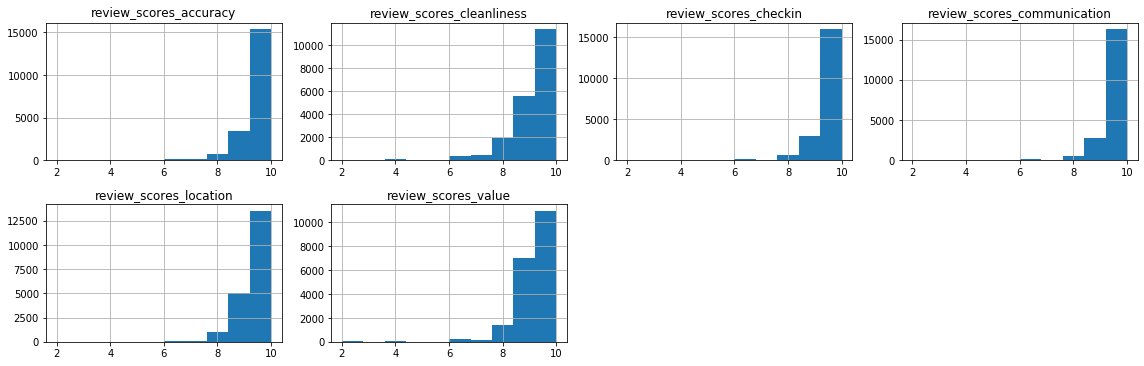

In [37]:
# Checking the distributions of the review ratings columns
variables_to_plot = [
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

fig = plt.figure(figsize=(16,10))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(4,4,i+1)
    airbnb_df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [38]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 7, 8, 9, 10],
               labels=['0-7','8','9', '10'],
               na_label='no reviews')

In [39]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 50, 80, 95, 100],
           labels=['0-49','50-79', '80-94', '95-100'],
           na_label='no reviews')

Replace cancellation policy with strict 14 with grace period and moderate

In [40]:
airbnb_df.cancellation_policy.value_counts()

flexible                       9602
strict_14_with_grace_period    7359
moderate                       7308
super_strict_30                  76
super_strict_60                  75
strict                            2
Name: cancellation_policy, dtype: int64

In [41]:
# Replacing categories
airbnb_df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

removing columns which will be correlated with number_of_reviews and so will be dropped.

In [42]:
airbnb_df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

# Exploratory data analysis

# Yearly rise in number of listings per host

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


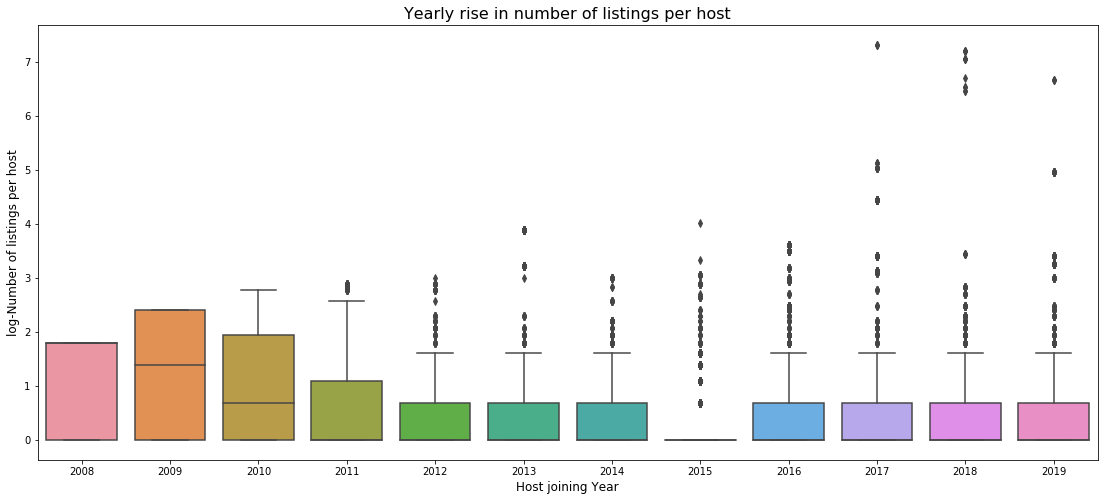

In [43]:
plt.figure(figsize=(19,8))
sns.boxplot(airbnb_df.host_since.dt.year, np.log(airbnb_df.host_listings_count))
plt.xlabel('Host joining Year', fontsize=12)
plt.ylabel('log-Number of listings per host', fontsize=12)
plt.title('Yearly rise in number of listings per host', fontsize=16)
plt.show()

# Yearly rise in Advertised Price for Airbnb listings

In [44]:
airbnb_df.first_review = pd.to_datetime(airbnb_df.first_review)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


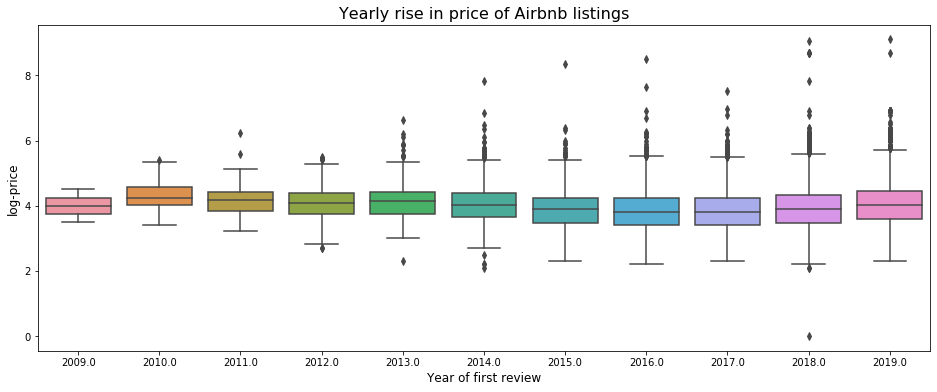

In [45]:
plt.figure(figsize=(16,6))
sns.boxplot(airbnb_df.first_review.dt.year, np.log(airbnb_df.price))
plt.xlabel('Year of first review', fontsize=12)
plt.ylabel('log-price', fontsize=12)
plt.title('Yearly rise in price of Airbnb listings', fontsize=16)
plt.show()

In [46]:
# Dropping host_since and first_review as they are no longer needed
airbnb_df.drop(['host_since', 'first_review'], axis=1, inplace=True)

In [47]:
print(f"advertised prices range from {min(airbnb_df.price)} to {max(airbnb_df.price)}.")

advertised prices range from 0 to 8983.


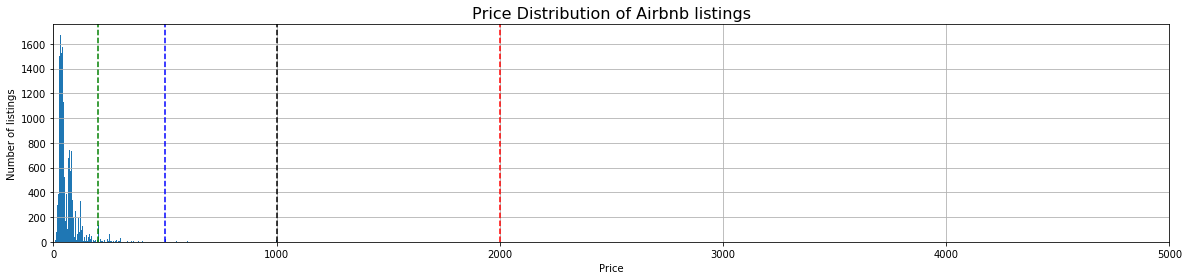

In [64]:
plt.figure(figsize=(20,4))
airbnb_df.price.hist(bins=2000, range = (0,5000))
plt.margins(x=0)
plt.axvline(200, color='green', linestyle='--')
plt.axvline(500, color='blue', linestyle='--')
plt.axvline(1000, color='black', linestyle='--')
plt.axvline(2000, color='red', linestyle='--')
plt.title("Price Distribution of Airbnb listings", fontsize=16)
plt.xlabel("Price")
plt.ylabel("Number of listings")
plt.show()

**Host listings count**

In [49]:
print("Median number of listings per host:", int(airbnb_df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(airbnb_df.host_listings_count.mean())))
print(f"{int(round(100*len(airbnb_df[airbnb_df.host_listings_count == 1])/len(airbnb_df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 3
65% of listings are from hosts with one listing.


**Number of people accommodated, bathrooms, bedrooms and beds**

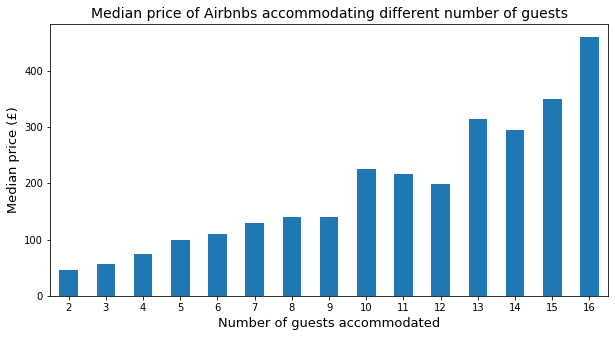

In [50]:
plt.figure(figsize=(10,5))
airbnb_df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

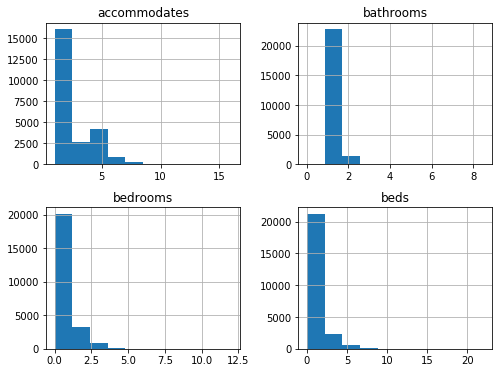

In [51]:
airbnb_df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

### Categorical features

Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

**Neighbourhood**

*Question: which areas have the most Airbnb properties, and which are the most expensive?* 

In [52]:
# Renaming the neighbourhood column
airbnb_df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the London borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('london_neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Kingston upon Thames,None,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,Croydon,None,"MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51..."
2,Bromley,None,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,Hounslow,None,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,Ealing,None,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."


In [53]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(airbnb_df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = airbnb_df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

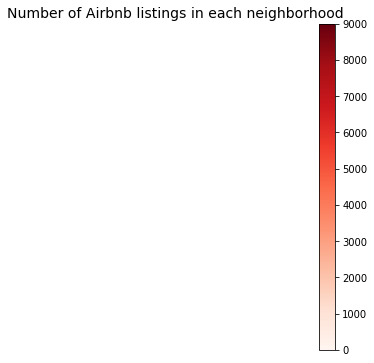

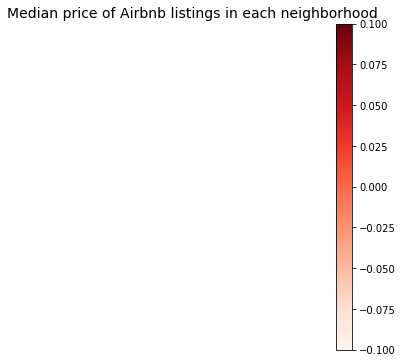

In [54]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Reds', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each neighborhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each neighborhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

**Property and room types**

*Question: what are the most common property and room types?*

In [55]:
def category_count_plot(col, figsize=(8,4)):
    plt.figure(figsize=figsize)
    airbnb_df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

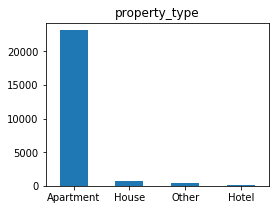

Apartment    0.945254
House        0.027557
Other        0.019900
Hotel        0.007289
Name: property_type, dtype: float64


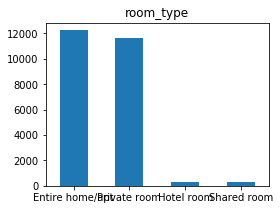

Entire home/apt    0.500369
Private room       0.475227
Hotel room         0.012407
Shared room        0.011997
Name: room_type, dtype: float64


In [56]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(airbnb_df[col].value_counts(normalize=True))

**Reviews**

*Question: what is the distribution of reviews like?*

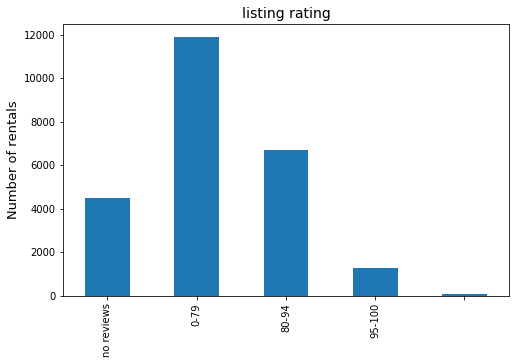

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('listing rating', fontsize=14)
airbnb_df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', ax=ax)
ax.set_xticklabels(labels=['no reviews','0-79','80-94','95-100'])
ax.set_xlabel('')
ax.set_ylabel('Number of rentals', fontsize=13)
plt.show()

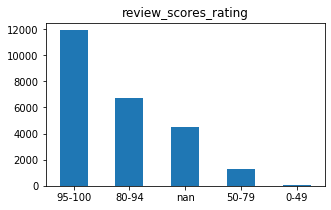

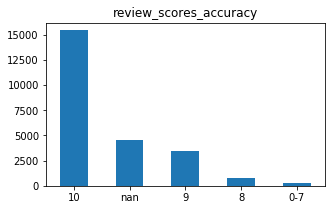

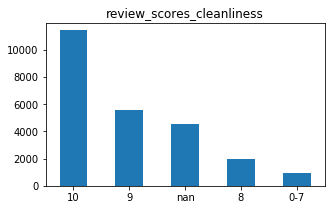

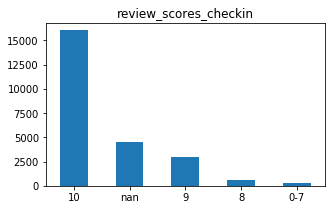

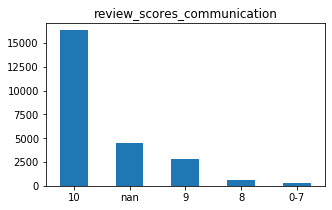

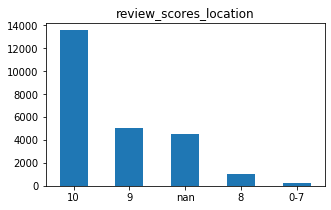

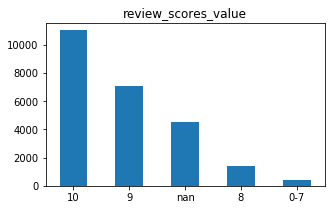

In [58]:
for col in list(airbnb_df.columns[airbnb_df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

### Boolean  features

In [59]:
def binary_count_and_price_plot(col, figsize=(10,6)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=12, y=1)
    
    airbnb_df.groupby(col).size().plot(kind='bar', ax=ax1)
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    airbnb_df.groupby(col).price.median().plot(kind='bar', ax=ax2)
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price')
    ax2.set_xlabel('')
    
    plt.show()

**Superhosts**

*Question: what proportion of Airbnb hosts are superhosts, and is it worth being one? (a question often asked by hosts)*

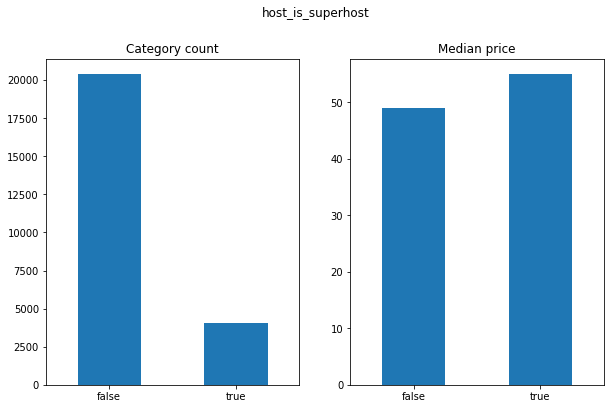

In [60]:
binary_count_and_price_plot('host_is_superhost')

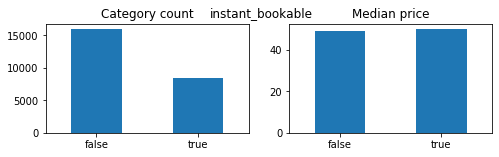

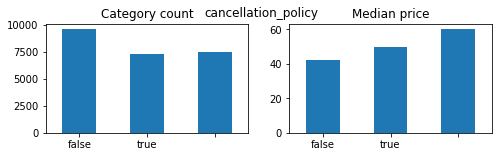

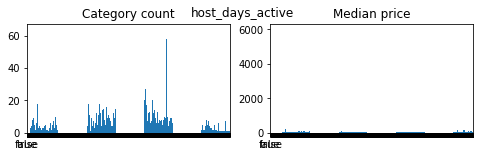

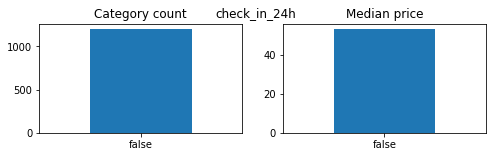

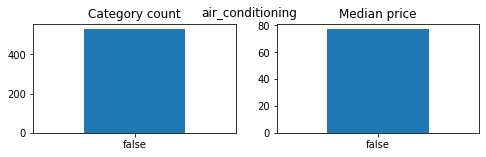

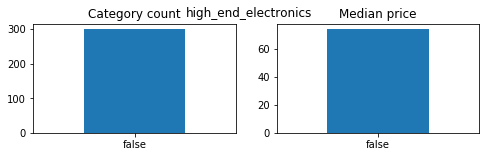

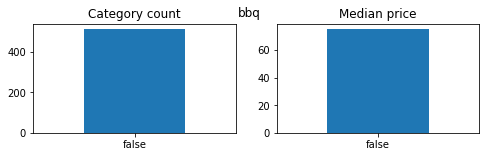

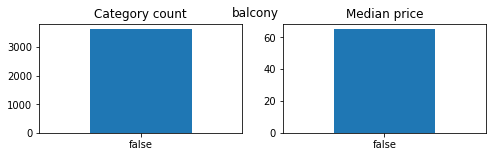

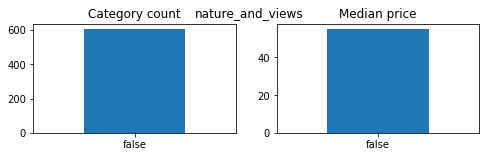

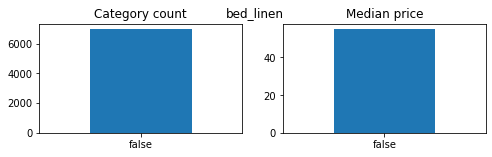

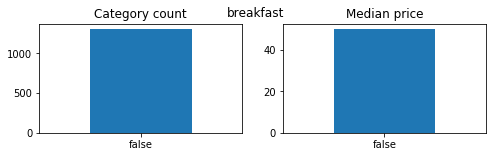

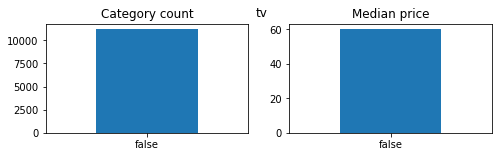

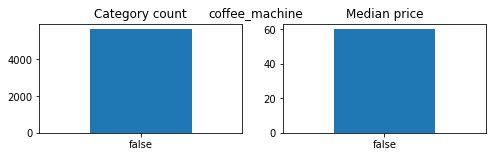

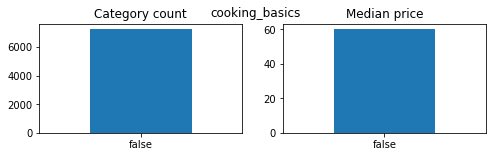

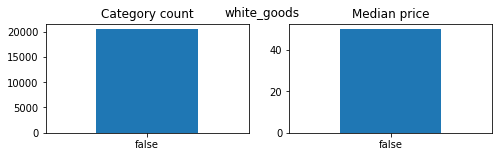

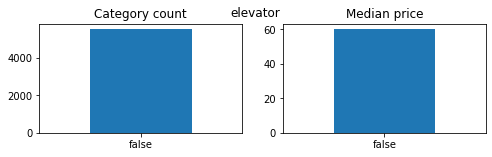

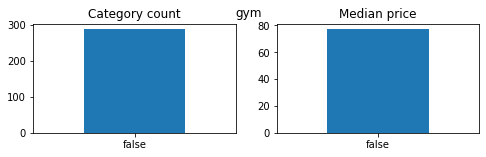

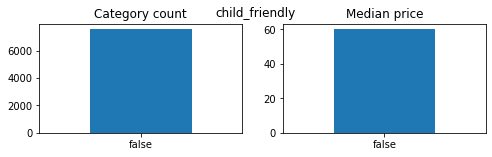

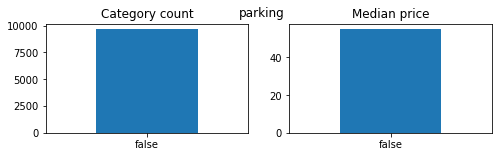

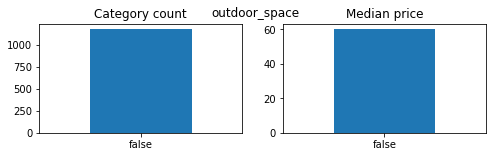

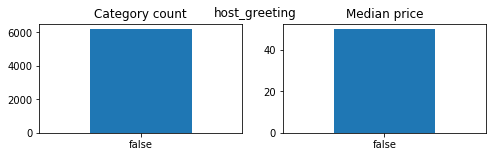

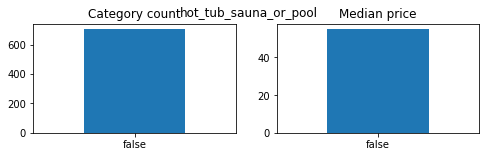

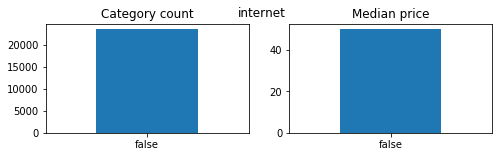

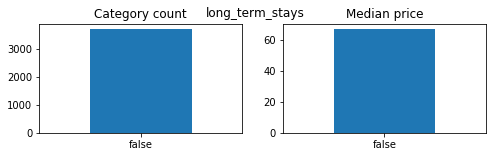

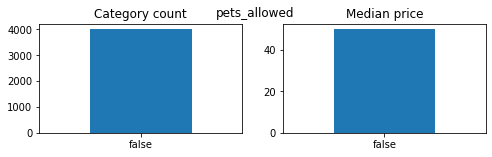

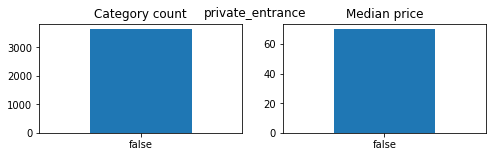

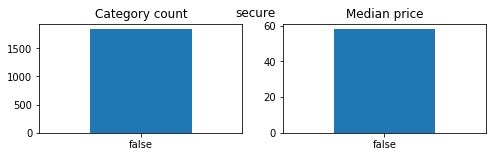

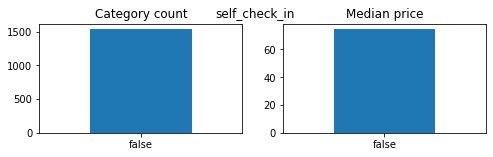

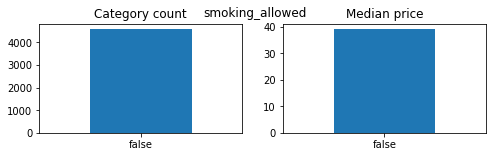

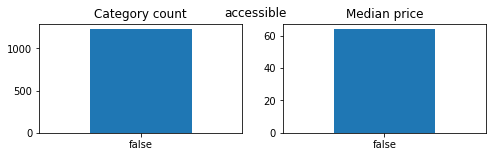

In [61]:
for col in airbnb_df.iloc[:,37:-1].columns:
    binary_count_and_price_plot(col, figsize=(8,2))

In [62]:
airbnb_df.to_csv("paris_cleaned_v2.csv.gz", index=False)